In [15]:
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
import optax
from functools import partial
from typing import Callable

from history import History

import matplotlib.pyplot as plt
import matplotlib.colors as colors

from cmap import Colormap
cmap = Colormap('crameri:batlow').to_mpl()

In [16]:
from problems import Burgers
problem = Burgers()

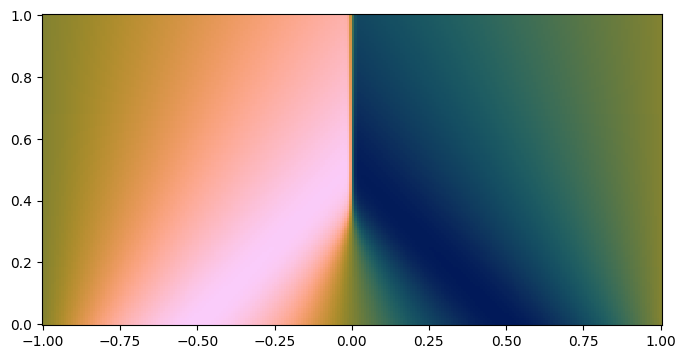

In [17]:
X, T, u_solution = problem.exact_solution(nx=256, nt=128)

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")
ax_exact = ax.pcolormesh(X, T, u_solution, cmap=cmap)

# Optimiser

In [18]:
class NielsenLevenbergMarquardt:
    """
    An implementation of Nielsen's modified Levenberg-Marquardt algorithm.

    This variant introduces a step-scaling factor `alpha` and uses a gain
    ratio `rho` for step acceptance, often leading to more robust convergence.
    """

    def __init__(
        self,
        init_lambda: float = 1e-3,
        epsilon: float = 1e-12, # Threshold for gain ratio acceptance
        min_lambda: float = 1e-7,
        max_lambda: float = 1e7,
        max_trials: int = 200,
    ):
        self.init_lambda = init_lambda
        self.epsilon = epsilon
        self.min_lambda = min_lambda
        self.max_lambda = max_lambda
        self.max_trials = max_trials

    def init(self, params: eqx.Module):
        """Initializes the optimizer state with the initial damping factor."""
        return {'lambda': self.init_lambda}

    def update(
        self,
        params: eqx.Module,
        state: optax.OptState,
        residual_fn: Callable[[eqx.Module], jax.Array]
    ):
        current_lambda = state['lambda']
        params_flat, unflatten = jax.flatten_util.ravel_pytree(params)

        def flat_residual_fn(p_flat):
            return residual_fn(unflatten(p_flat))

        residuals = residual_fn(params)
        current_loss = jnp.mean(residuals**2)
        current_chi = 0.5 * jnp.sum(residuals**2)

        J = jax.jacfwd(flat_residual_fn)(params_flat)
        g = J.T @ residuals # Gradient
        U, S, Vt = jnp.linalg.svd(J, full_matrices=False)
        H_approx = J.T @ J # Approximate Hessian

        def evaluate_trial_step(loop_val):
            trial_lambda, _, trial_count = loop_val

            # 1. Calculate the unscaled step direction `h`
            h = -Vt.T @ ( (S / (S**2 + trial_lambda)) * (U.T @ residuals) )

            # 2. Calculate the step-scaling factor `alpha`
            g_dot_h = g.T @ h
            # Loss at the unscaled step point
            chi_at_h = 0.5 * jnp.sum(flat_residual_fn(params_flat + h)**2)
            alpha_denom = (chi_at_h - current_chi) + (2 * g_dot_h)
            alpha = g_dot_h / (alpha_denom + 1e-9) # Add epsilon for stability
            
            # 3. Calculate the gain ratio `rho` for the SCALED step
            h_scaled = alpha * h
            
            # Actual reduction in chi
            chi_at_h_scaled = 0.5 * jnp.sum(flat_residual_fn(params_flat + h_scaled)**2)
            actual_reduction = current_chi - chi_at_h_scaled
            
            # Predicted reduction from the quadratic model
            # L(h_scaled) = L(0) + g.T @ h_scaled + 0.5 * h_scaled.T @ H @ h_scaled
            predicted_reduction = -(g.T @ h_scaled + 0.5 * h_scaled.T @ H_approx @ h_scaled)
            
            rho = actual_reduction / (predicted_reduction + 1e-9)

            # 4. Use `rho` to decide if the step is accepted
            accepted = rho > self.epsilon

            # 5. Update lambda based on Nielsen's rules
            def accepted_fn():
                # Decrease lambda if step is good
                return jnp.maximum(self.min_lambda, trial_lambda / 2)
            
            def rejected_fn():
                # Increase lambda if step is bad
                # increase_term = jnp.abs(chi_at_h_scaled - current_chi) / (2 * alpha + 1e-9)
                return jnp.minimum(self.max_lambda, trial_lambda * 2)

            new_lambda = jax.lax.cond(accepted, accepted_fn, rejected_fn)

            return new_lambda, accepted, trial_count + 1

        def continue_until_accepted(loop_val):
            _, accepted, trial_count = loop_val
            return jnp.logical_and(jnp.logical_not(accepted), trial_count < self.max_trials)

        # --- Run the loop to find an acceptable step and lambda ---
        final_lambda, step_was_accepted, trial_count = jax.lax.while_loop(
            continue_until_accepted, evaluate_trial_step, (current_lambda, False, 0)
        )

        # --- Recalculate the final accepted step ---
        # We need to recalculate `h` and `alpha` with the final lambda
        h_final = -Vt.T @ ( (S / (S**2 + final_lambda)) * (U.T @ residuals) )
        chi_at_h_final = 0.5 * jnp.sum(flat_residual_fn(params_flat + h_final)**2)
        g_dot_h_final = g.T @ h_final
        alpha_denom_final = (chi_at_h_final - current_chi) + (2 * g_dot_h_final)
        alpha_final = g_dot_h_final / (alpha_denom_final + 1e-9)

        # Final update is the scaled step; if no step was accepted, update is zero
        final_delta = jax.lax.cond(
            step_was_accepted,
            lambda: alpha_final * h_final,
            lambda: jnp.zeros_like(params_flat)
        )
        
        updates = unflatten(final_delta)
        new_state = {'lambda': final_lambda}

        metrics = {
            'loss': current_loss,
            'singular_values': S,
            'search_direction_norm': jnp.linalg.norm(final_delta),
            'lambda': final_lambda,
            'alpha': jax.lax.cond(step_was_accepted, lambda: alpha_final, lambda: 0.0),
            'number of trails': trial_count
        }

        return current_loss, updates, new_state, metrics


@partial(jax.jit, static_argnums=(3, 4))
def train_step(params, static_parts, opt_state, optimiser, problem, collocation_points):
    def residual_fn_for_optimizer(p):
        rebuilt_model = eqx.combine(p, static_parts)
        return problem.physics_residual(problem.residual_fn, rebuilt_model, collocation_points, problem.nu)

    loss, updates, new_opt_state, metrics = optimiser.update(params, opt_state, residual_fn_for_optimizer)
    new_params = eqx.apply_updates(params, updates)
    
    return new_params, new_opt_state, loss, metrics

In [19]:
key = jax.random.PRNGKey(42)

# --- Hyperparameters ---
n_epochs = 20
n_collocation_points = 2**13
layer_sizes = [2, 12, 12, 12, 12, 12, 1]
# -----------------------

model_key, data_key = jax.random.split(key)
model = problem.FCN(model_key, layer_sizes)
params, static = eqx.partition(model, eqx.is_array)

optimiser = NielsenLevenbergMarquardt(
)
history = History()

opt_state = optimiser.init(params)
collocation_points = problem.get_collocation_points(n_collocation_points, seed=1)

print(f"Starting PINN training with {type(optimiser).__name__}...")
for epoch in range(n_epochs):
    params, opt_state, loss_val, metrics = train_step(
        params, static, opt_state, optimiser, problem, collocation_points
    )
    history.record(metrics)
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss_val.item():.3e}")

model = eqx.combine(params, static)
print("Training complete.")

Starting PINN training with NielsenLevenbergMarquardt...
Epoch 20, Loss: 6.565e+00
Training complete.


Relative L2 Error: 9.711e-01


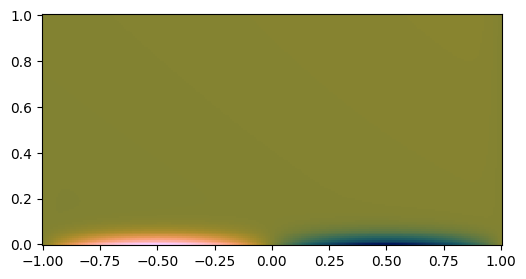

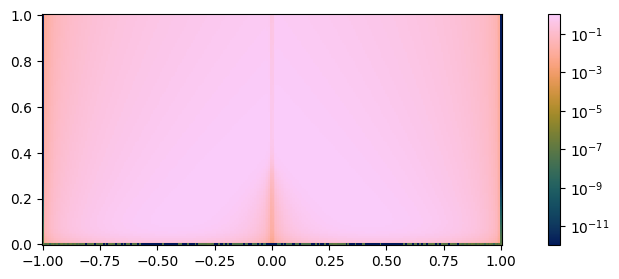

In [20]:
u_pred = model.predict(X, T)

error = jnp.abs(u_solution - u_pred)
rel_l2_error = jnp.linalg.norm(error) / jnp.linalg.norm(u_solution)

print(f"Relative L2 Error: {rel_l2_error:.3e}")

fig, ax = plt.subplots(figsize=(8, 3))
ax.set_aspect("equal")
nn_solution = ax.pcolormesh(X, T, u_pred, cmap=cmap)
plt.show()

norm = colors.LogNorm(vmin=error.min() + 1e-12, vmax=error.max())
fig, ax = plt.subplots(figsize=(12, 3))
ax.set_aspect("equal")
nn_error = ax.pcolormesh(X, T, np.abs(error) + 1e-12, norm=norm, cmap=cmap)
fig.colorbar(nn_error, ax=ax, pad=0.05)
plt.show()

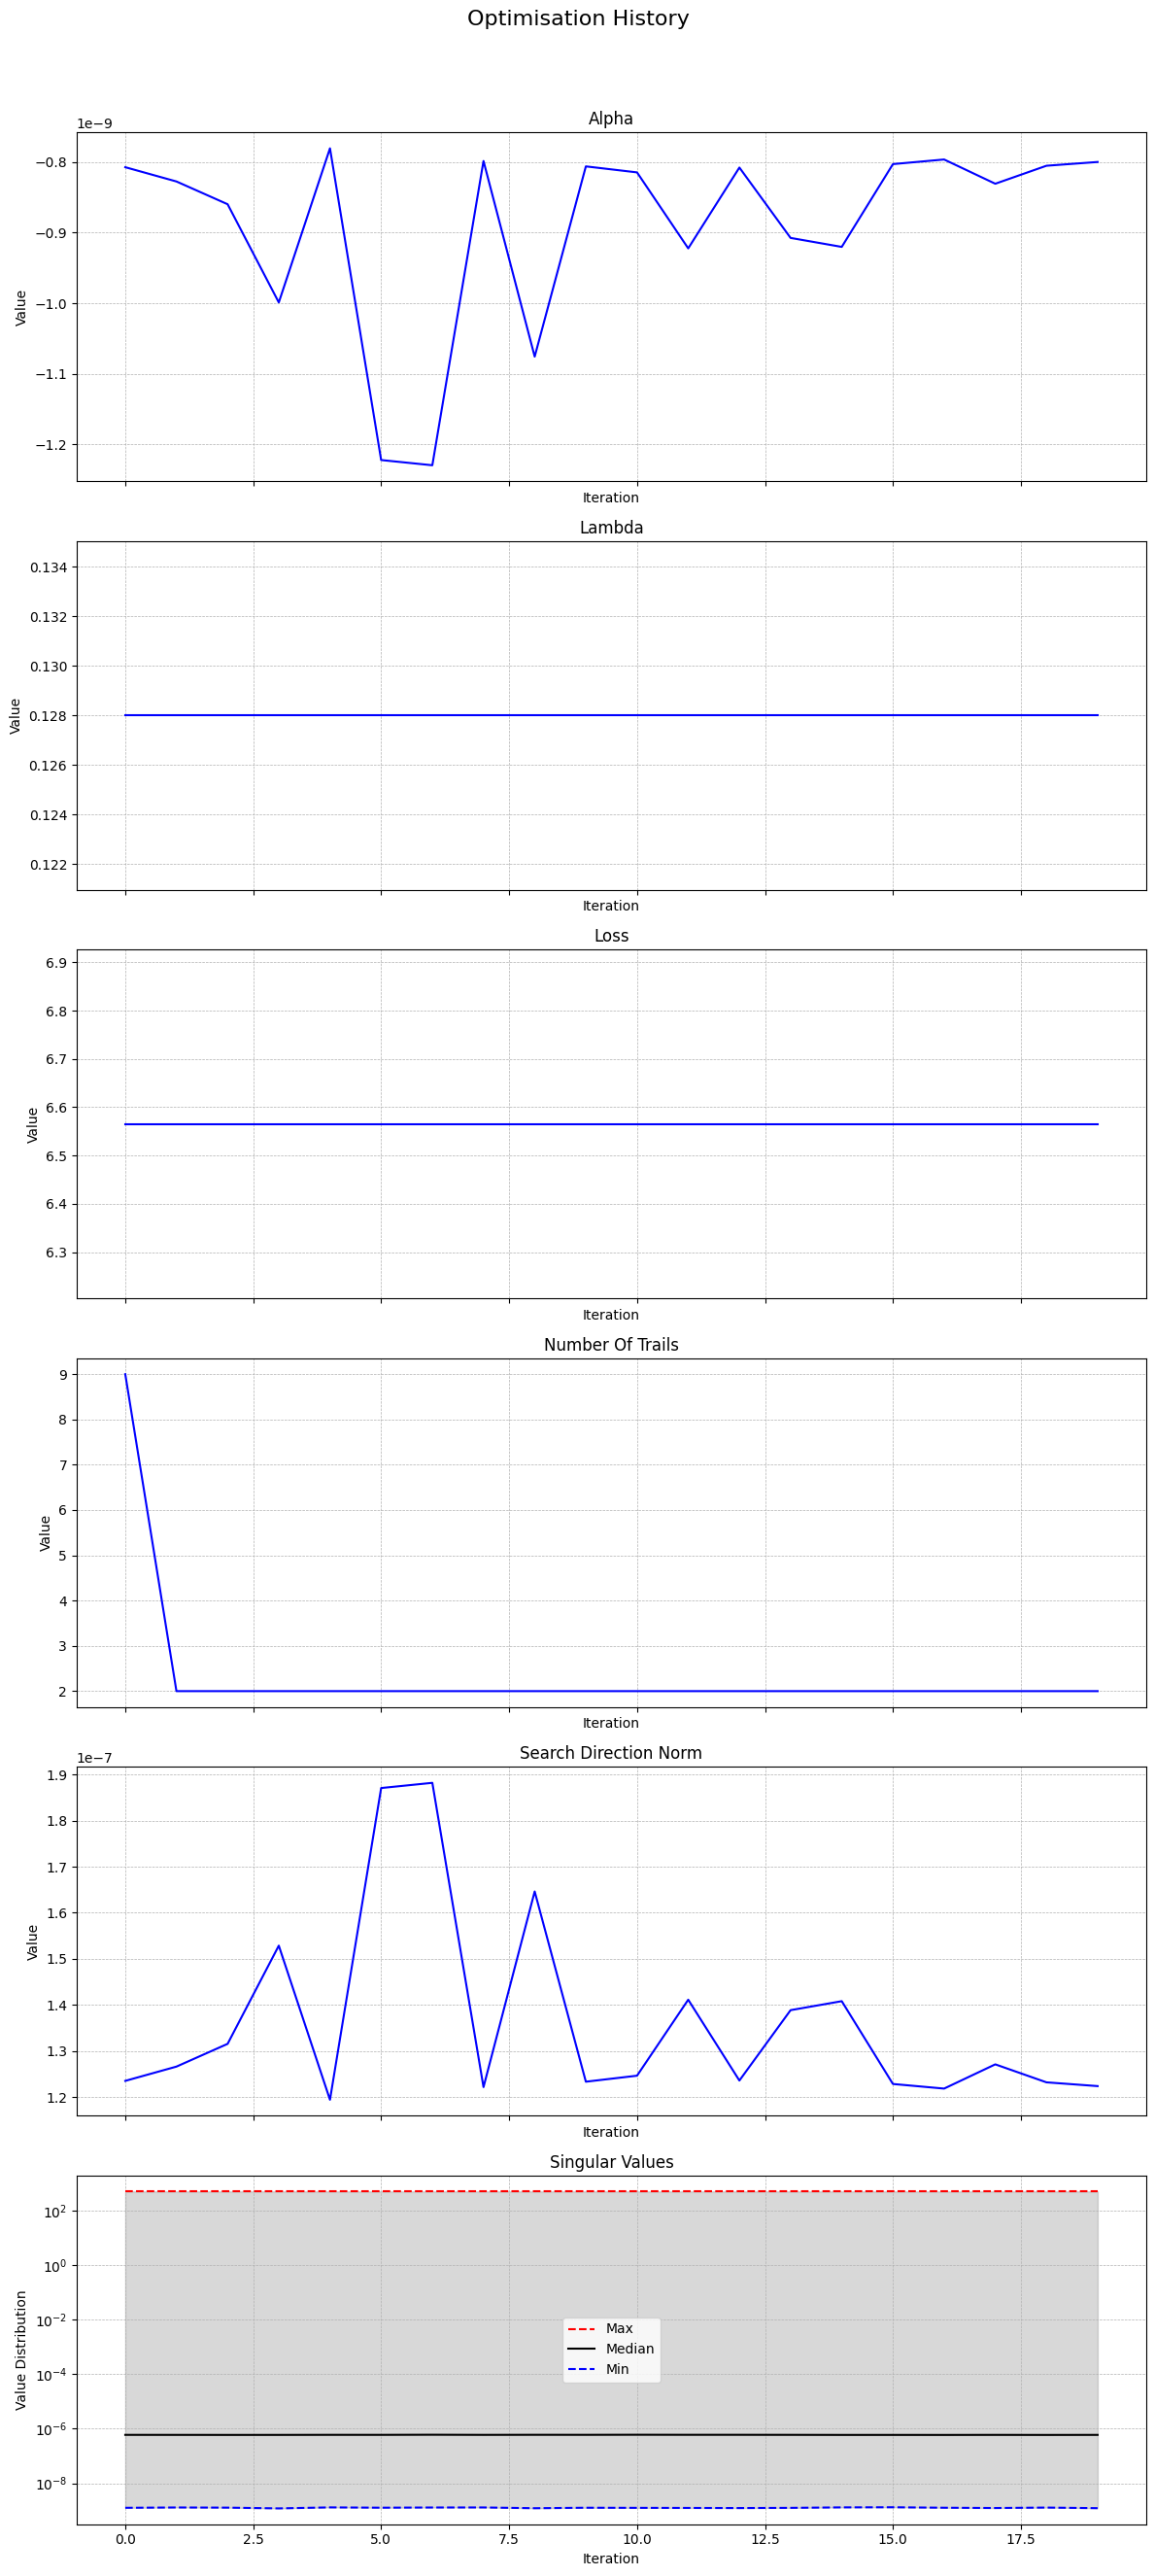

In [21]:
history.plot()